In [42]:
import os
import pandas as pd
import wfdb

# путь к папке с PTB-XL
data_root = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
db_csv = os.path.join(data_root, "ptbxl_database.csv")

# читаем CSV с метаданными
df = pd.read_csv(db_csv, index_col="ecg_id")

In [31]:
# === Функции для загрузки данных и предобработки ===
def load_ptbxl_lr(ecg_id):
    """Загрузка LR (100Hz) сигнала"""
    row = df.loc[ecg_id]
    fn = os.path.join(data_root, row["filename_lr"])
    sig, meta = wfdb.rdsamp(fn)
    sig = sig.T  # (12, samples)
    return sig, meta

from scipy.signal import resample
from biosppy.signals.tools import filter_signal
import numpy as np

def apply_filter(signal, filter_bandwidth, fs=100):
    order = int(0.3 * fs)
    s, _, _ = filter_signal(signal=signal, ftype='FIR', band='bandpass',
                            order=order, frequency=filter_bandwidth,
                            sampling_rate=fs)
    return s

def scale_minus1_1(seq, eps=1e-8):
    minv = np.min(seq, axis=1, keepdims=True)
    maxv = np.max(seq, axis=1, keepdims=True)
    return 2 * (seq - minv) / (maxv - minv + eps) - 1

def preprocess_one(sig, orig_fs, target_fs=100, duration_sec=5, band=[0.5,40]):
    """Сигнал на входе: (12, samples). Возвращает (12, target_fs*duration_sec)"""
    channels, length = sig.shape
    assert channels == 12, "Ожидается 12 каналов"
    
    n_take = int(duration_sec * orig_fs)
    sig_cut = sig[:, :n_take]
    
    n_target = int(duration_sec * target_fs)
    sig_rs = resample(sig_cut, n_target, axis=1)
    
    sig_f = apply_filter(sig_rs, filter_bandwidth=band, fs=target_fs)
    sig_s = scale_minus1_1(sig_f)
    
    assert sig_s.shape == (12, n_target)
    assert np.isfinite(sig_s).all()
    
    return sig_s


In [32]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

hubert_ecg = AutoModel.from_pretrained("Edoardo-BS/hubert-ecg-base", trust_remote_code=True).to(device)
hubert_ecg.eval()


Device: mps


HuBERTECG(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(4,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-2): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (3-4): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Parame

In [33]:
ecg_id = df.index[0]
sig, meta = load_ptbxl_lr(ecg_id)
sig_pre = preprocess_one(sig, orig_fs=int(meta.get("fs", 100)))

lead_index = 1  # II отведение
lead_signal = sig_pre[lead_index]

x = torch.tensor(lead_signal, dtype=torch.float32)[None, :].to(device)  # (1, 500)
with torch.no_grad():
    output = hubert_ecg(input_values=x)
    emb = output.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

print("Embedding shape:", emb.shape)
print("First 10 values:", emb[:10])


Embedding shape: (768,)
First 10 values: [ 0.4711432   0.54638803 -0.34480533  0.18720447 -0.17044851  1.415309
  1.4027592  -0.7054438   0.18310507  0.52137345]


In [6]:
import os
import tqdm
import numpy as np
import torch

save_dir = "/Users/elizaveta/vs project/jupyter project"
os.makedirs(save_dir, exist_ok=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

n_samples = 3000   # или меньше/больше, сколько нужно
chunk_size = 50    # меньше, чтобы не перегружать память

for start in range(0, n_samples, chunk_size):
    end = min(start + chunk_size, n_samples)
    actual_chunk_size = end - start
    
    embeddings_chunk = np.zeros((actual_chunk_size, 12, 768), dtype=np.float32)
    
    for i, ecg_id in enumerate(tqdm.tqdm(df.index[start:end], desc=f"Processing {start}-{end}")):
        sig, meta = load_ptbxl_lr(ecg_id)
        sig_pre = preprocess_one(sig, orig_fs=int(meta.get("fs", 100)))
        
        for lead in range(12):
            x = torch.tensor(sig_pre[lead], dtype=torch.float32)[None, :].to(device)
            with torch.no_grad():
                output = hubert_ecg(input_values=x)
                emb = output.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
            embeddings_chunk[i, lead] = emb
    
    # Сохраняем chunk на диск
    chunk_file = os.path.join(save_dir, f"embeddings_{start}_{end}.npy")
    np.save(chunk_file, embeddings_chunk)
    print(f"Saved {chunk_file}")


Device: mps


Processing 0-50: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_0_50.npy


Processing 50-100: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_50_100.npy


Processing 100-150: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_100_150.npy


Processing 150-200: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_150_200.npy


Processing 200-250: 100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_200_250.npy


Processing 250-300: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_250_300.npy


Processing 300-350: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_300_350.npy


Processing 350-400: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_350_400.npy


Processing 400-450: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_400_450.npy


Processing 450-500: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_450_500.npy


Processing 500-550: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_500_550.npy


Processing 550-600: 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_550_600.npy


Processing 600-650: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_600_650.npy


Processing 650-700: 100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_650_700.npy


Processing 700-750: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_700_750.npy


Processing 750-800: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_750_800.npy


Processing 800-850: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_800_850.npy


Processing 850-900: 100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_850_900.npy


Processing 900-950: 100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_900_950.npy


Processing 950-1000: 100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_950_1000.npy


Processing 1000-1050: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1000_1050.npy


Processing 1050-1100: 100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1050_1100.npy


Processing 1100-1150: 100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1100_1150.npy


Processing 1150-1200: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1150_1200.npy


Processing 1200-1250: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1200_1250.npy


Processing 1250-1300: 100%|██████████| 50/50 [00:09<00:00,  5.46it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1250_1300.npy


Processing 1300-1350: 100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1300_1350.npy


Processing 1350-1400: 100%|██████████| 50/50 [00:09<00:00,  5.38it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1350_1400.npy


Processing 1400-1450: 100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1400_1450.npy


Processing 1450-1500: 100%|██████████| 50/50 [00:08<00:00,  5.60it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1450_1500.npy


Processing 1500-1550: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1500_1550.npy


Processing 1550-1600: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1550_1600.npy


Processing 1600-1650: 100%|██████████| 50/50 [00:09<00:00,  5.46it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1600_1650.npy


Processing 1650-1700: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1650_1700.npy


Processing 1700-1750: 100%|██████████| 50/50 [00:09<00:00,  5.38it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1700_1750.npy


Processing 1750-1800: 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1750_1800.npy


Processing 1800-1850: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1800_1850.npy


Processing 1850-1900: 100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1850_1900.npy


Processing 1900-1950: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1900_1950.npy


Processing 1950-2000: 100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_1950_2000.npy


Processing 2000-2050: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2000_2050.npy


Processing 2050-2100: 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2050_2100.npy


Processing 2100-2150: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2100_2150.npy


Processing 2150-2200: 100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2150_2200.npy


Processing 2200-2250: 100%|██████████| 50/50 [00:09<00:00,  5.40it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2200_2250.npy


Processing 2250-2300: 100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2250_2300.npy


Processing 2300-2350: 100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2300_2350.npy


Processing 2350-2400: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2350_2400.npy


Processing 2400-2450: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2400_2450.npy


Processing 2450-2500: 100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2450_2500.npy


Processing 2500-2550: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2500_2550.npy


Processing 2550-2600: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2550_2600.npy


Processing 2600-2650: 100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2600_2650.npy


Processing 2650-2700: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2650_2700.npy


Processing 2700-2750: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2700_2750.npy


Processing 2750-2800: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2750_2800.npy


Processing 2800-2850: 100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2800_2850.npy


Processing 2850-2900: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2850_2900.npy


Processing 2900-2950: 100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_2900_2950.npy


Processing 2950-3000: 100%|██████████| 50/50 [00:09<00:00,  5.42it/s]

Saved /Users/elizaveta/vs project/jupyter project/embeddings_2950_3000.npy


In [ ]:
import os
import numpy as np

save_dir = "/Users/elizaveta/vs project/jupyter project"
n_samples = 3000  # сколько сигналов построено
chunk_files = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.startswith("embeddings_") and f.endswith(".npy")]

all_embeddings = []
for f in sorted(chunk_files):
    chunk = np.load(f)  # shape: (chunk_size, 12, 768)
    all_embeddings.append(chunk)

all_embeddings = np.vstack(all_embeddings)  # (n_samples, 12, 768)
print("All embeddings shape:", all_embeddings.shape)  # должно быть (3000, 12, 768)


All embeddings shape: (3000, 12, 768)


In [2]:
# Для UMAP/KMeans нужно 2D: (n_samples, features)
# Разворачиваем каждую матрицу 12x768 в вектор 9216
X = all_embeddings.reshape(all_embeddings.shape[0], -1)
print("X shape for clustering:", X.shape)  # (3000, 9216)


X shape for clustering: (3000, 9216)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


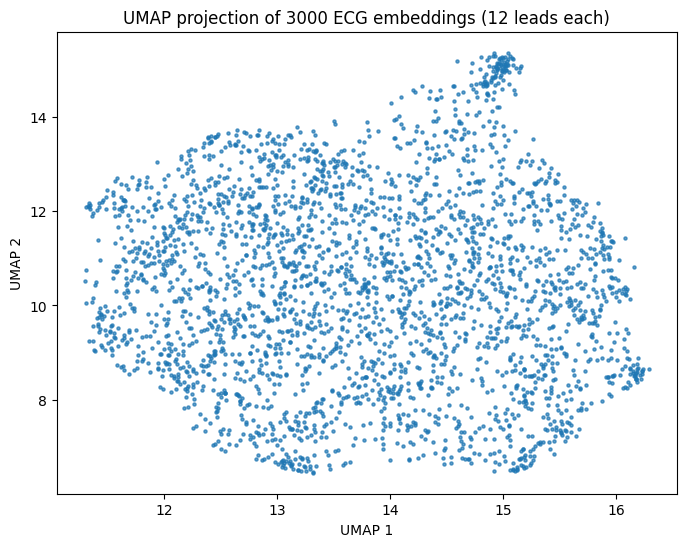

In [3]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
X_embedded = reducer.fit_transform(X)  # shape (3000, 2)

plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=5, alpha=0.7)
plt.title("UMAP projection of 3000 ECG embeddings (12 leads each)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3

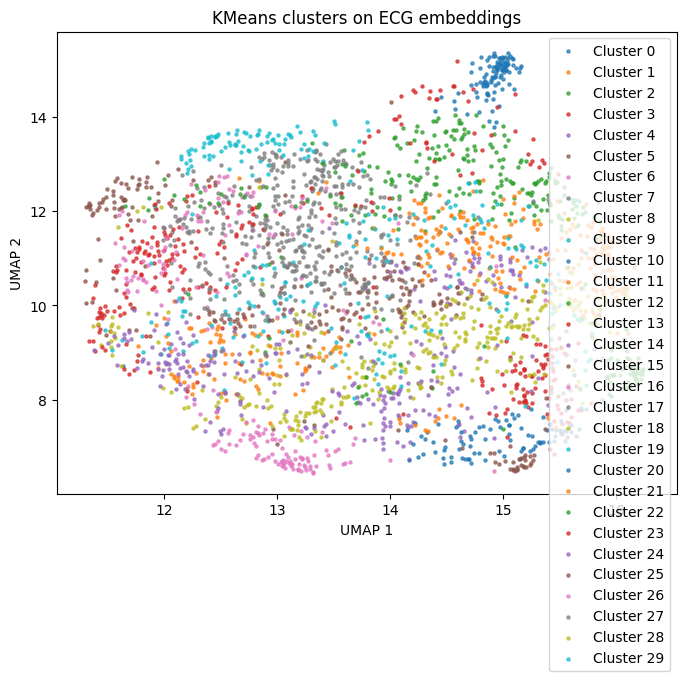

In [8]:
from sklearn.cluster import KMeans

n_clusters = 30  # можно менять
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Визуализация кластеров через UMAP
plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(X_embedded[labels==i,0], X_embedded[labels==i,1], s=5, alpha=0.7, label=f"Cluster {i}")
plt.title("KMeans clusters on ECG embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, labels)
print("Silhouette score:", sil_score)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Silhouette score: 0.017656557261943817


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


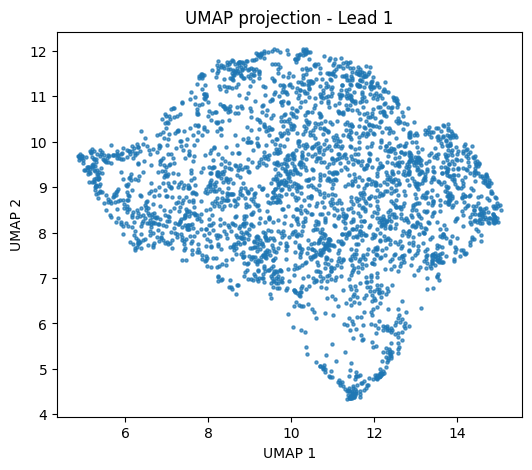

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


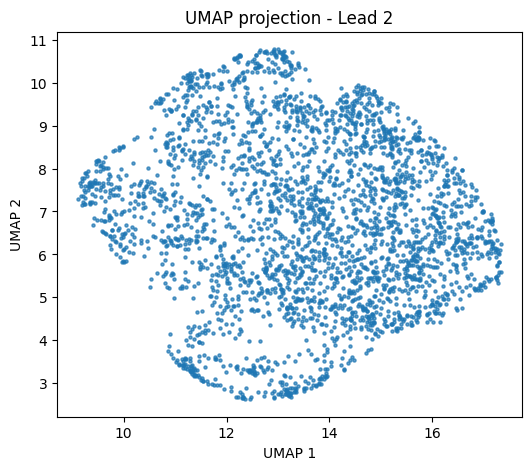

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


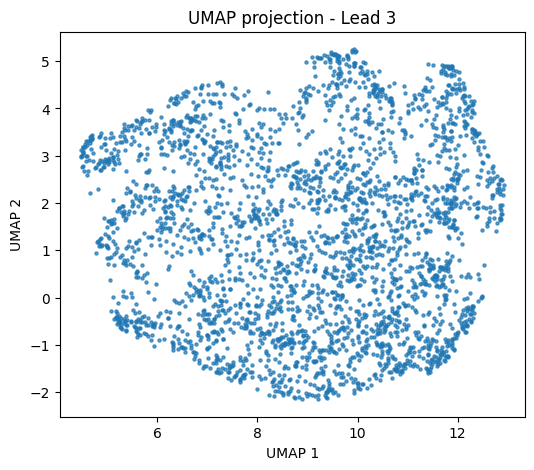

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


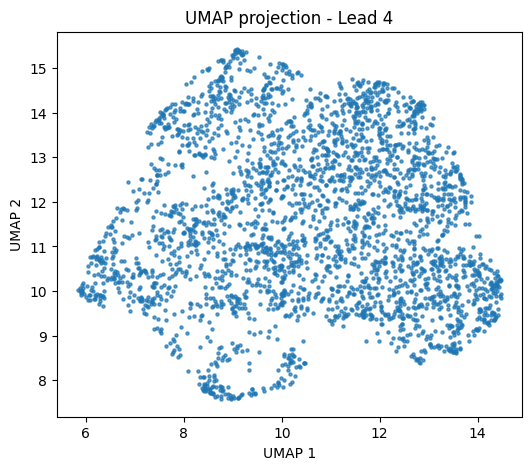

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


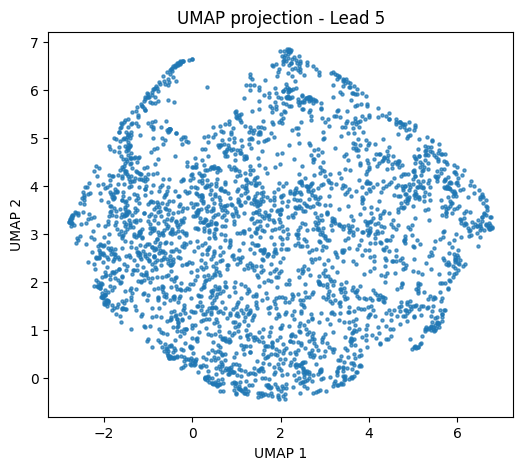

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


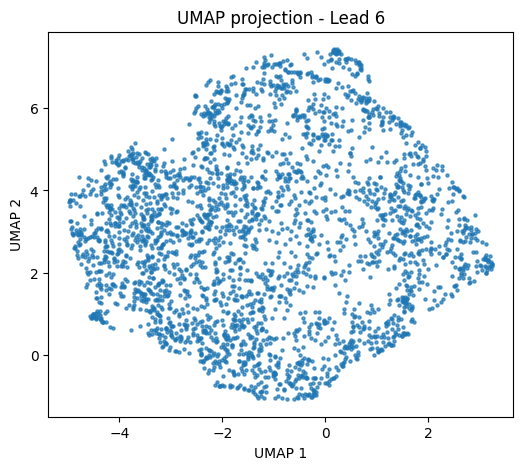

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


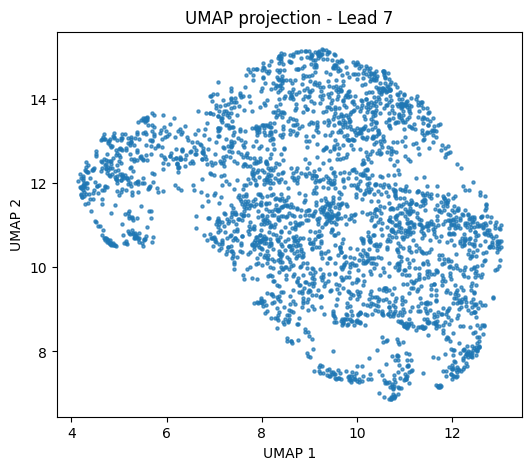

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


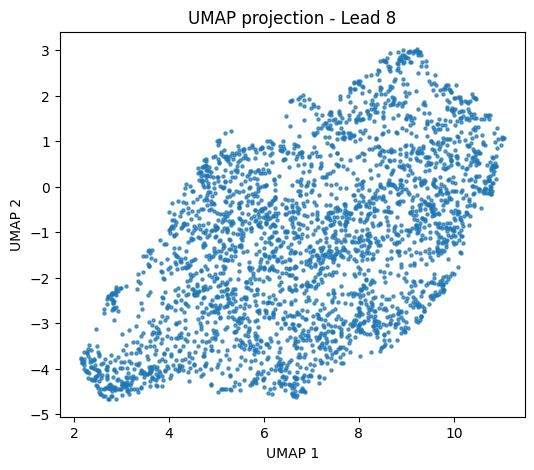

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


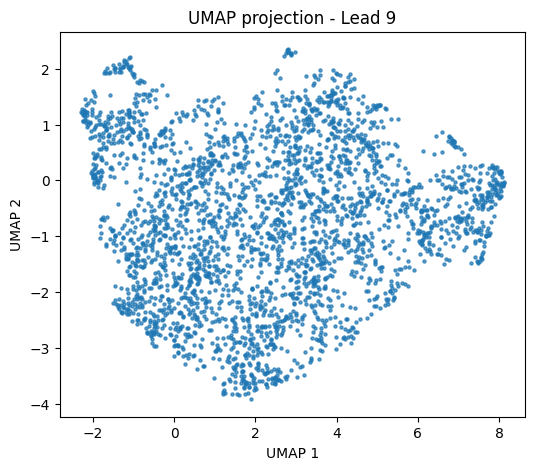

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


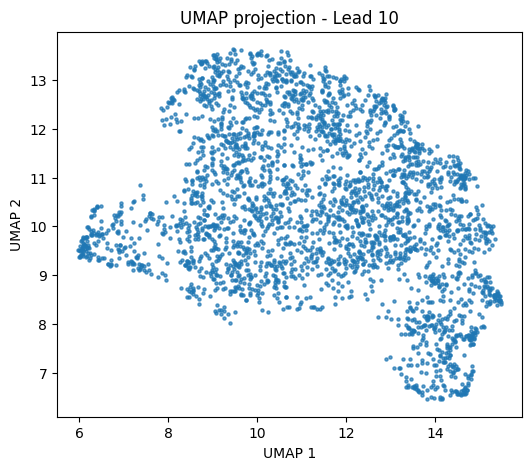

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


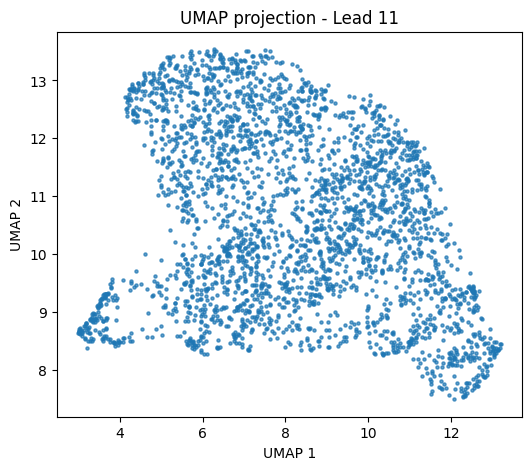

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


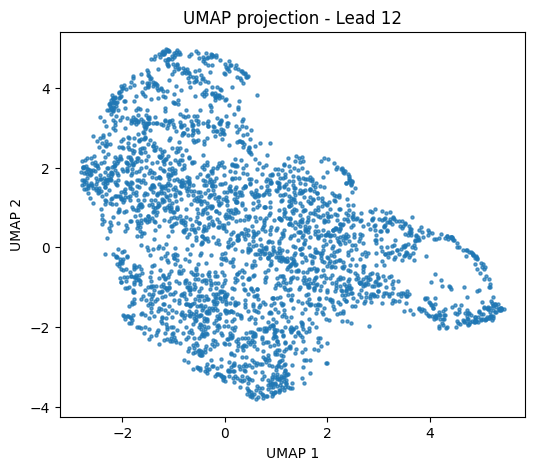

In [10]:
import umap
import matplotlib.pyplot as plt

n_leads = 12

for lead in range(n_leads):
    # Берем только это отведение (n_samples, 768)
    X_lead = all_embeddings[:, lead, :]
    
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
    X_embedded = reducer.fit_transform(X_lead)
    
    plt.figure(figsize=(6,5))
    plt.scatter(X_embedded[:,0], X_embedded[:,1], s=5, alpha=0.7)
    plt.title(f"UMAP projection - Lead {lead+1}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()


In [17]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

# Предположим, что all_embeddings имеет форму (n_samples, 12, 768)
# Выбираем только Lead II (индекс 1)
X_lead2 = all_embeddings[:, 1, :]  # shape: (n_samples, 768)

# Кластеризация
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_lead2)

# Silhouette score
score = silhouette_score(X_lead2, labels)
print("Silhouette score:", score)

# Вычисление средних расстояний
intra_dists = []
inter_dists = []

for cluster_id in range(n_clusters):
    idxs = np.where(labels == cluster_id)[0]
    cluster_points = X_lead2[idxs]
    # среднее внутрикластерное расстояние
    if len(cluster_points) > 1:
        dists = pairwise_distances(cluster_points)
        intra_dists.append(np.mean(dists))
    # межкластерное расстояние к центру
    centroid = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    for other_id in range(n_clusters):
        if other_id != cluster_id:
            other_centroid = kmeans.cluster_centers_[other_id].reshape(1, -1)
            inter_dists.append(np.linalg.norm(centroid - other_centroid))

print("Average intra-cluster distance:", np.mean(intra_dists))
print("Average inter-cluster distance:", np.mean(inter_dists))

# Вывод, какие сигналы попали в каждый кластер
for cluster_id in range(n_clusters):
    idxs = np.where(labels == cluster_id)[0]
    print(f"Cluster {cluster_id}: {len(idxs)} signals -> indices: {idxs.tolist()}")


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3

Silhouette score: 0.056094955652952194
Average intra-cluster distance: 11.653711
Average inter-cluster distance: 13.11508
Cluster 0: 56 signals -> indices: [49, 81, 174, 180, 197, 243, 244, 338, 503, 672, 720, 762, 770, 804, 811, 826, 847, 921, 934, 937, 1123, 1230, 1253, 1322, 1323, 1352, 1412, 1434, 1447, 1449, 1481, 1558, 1644, 1672, 1720, 1761, 1771, 1802, 1907, 1940, 2004, 2030, 2053, 2175, 2220, 2229, 2288, 2408, 2439, 2605, 2624, 2672, 2809, 2836, 2890, 2933]
Cluster 1: 118 signals -> indices: [62, 80, 87, 124, 142, 160, 237, 257, 323, 331, 333, 342, 343, 396, 421, 440, 446, 460, 510, 519, 527, 528, 570, 572, 585, 610, 627, 652, 678, 715, 735, 764, 780, 799, 865, 889, 899, 909, 933, 949, 967, 1099, 1134, 1155, 1186, 1225, 1246, 1265, 1287, 1297, 1305, 1329, 1331, 1357, 1368, 1379, 1380, 1386, 1397, 1421, 1437, 1450, 1454, 1504, 1522, 1535, 1559, 1592, 1594, 1654, 1719, 1723, 1727, 1758, 1804, 1806, 1870, 1881, 1882, 1909, 1973, 1984, 1985, 1991, 2088, 2132, 2163, 2208, 2230, 233

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3

Silhouette score: 0.04716155678033829
Average intra-cluster distance: 11.072078
Average inter-cluster distance: 13.453858


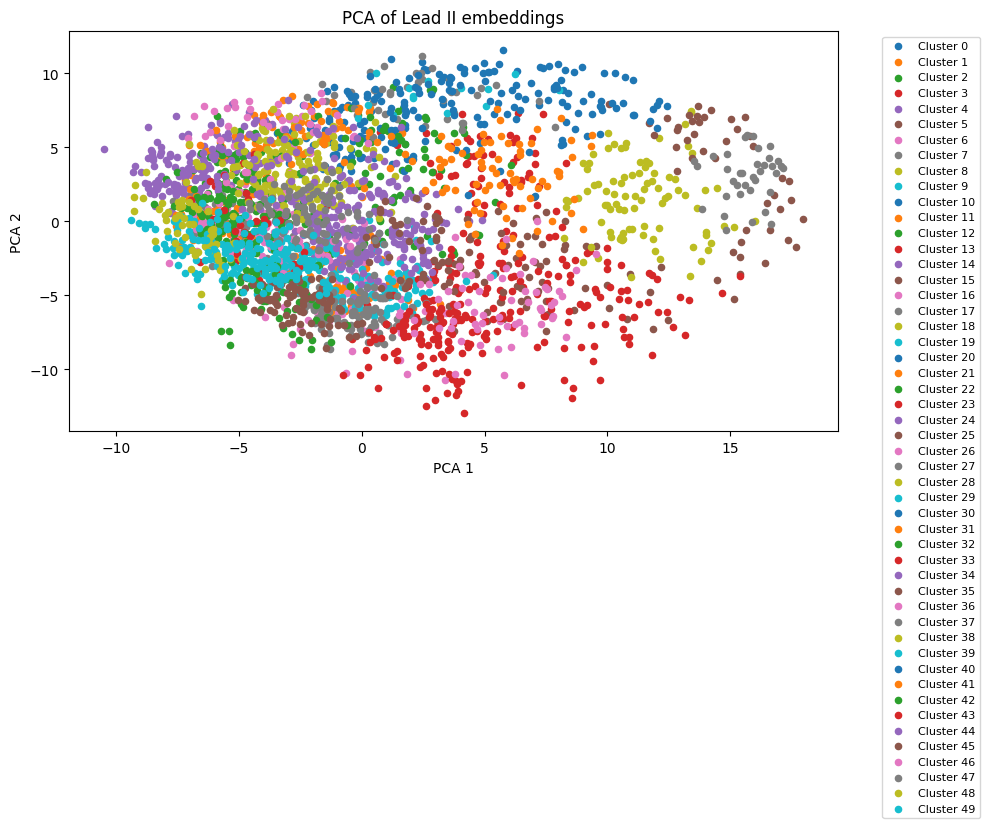

Cluster 0: 20 signals -> indices: [243, 338, 458, 672, 1123, 1412, 1434, 1449, 1481, 1720, 1771, 1802, 2030, 2229, 2288, 2408, 2605, 2809, 2890, 2933]
Cluster 1: 55 signals -> indices: [80, 117, 124, 132, 179, 181, 229, 268, 278, 333, 447, 585, 648, 715, 899, 1091, 1134, 1155, 1225, 1297, 1348, 1357, 1390, 1397, 1403, 1437, 1492, 1504, 1614, 1661, 1718, 1719, 1736, 1756, 1801, 1909, 1973, 2138, 2166, 2313, 2314, 2315, 2413, 2433, 2447, 2511, 2555, 2584, 2700, 2727, 2768, 2782, 2848, 2885, 2953]
Cluster 2: 39 signals -> indices: [61, 214, 341, 454, 597, 599, 620, 641, 870, 929, 959, 987, 1010, 1254, 1267, 1277, 1351, 1377, 1440, 1660, 1722, 1849, 1925, 2031, 2046, 2107, 2124, 2260, 2265, 2341, 2470, 2479, 2491, 2666, 2893, 2932, 2937, 2943, 2971]
Cluster 3: 55 signals -> indices: [266, 330, 501, 534, 564, 637, 739, 769, 796, 816, 843, 852, 887, 911, 1053, 1065, 1067, 1086, 1105, 1110, 1137, 1141, 1172, 1221, 1243, 1269, 1364, 1419, 1420, 1480, 1531, 1538, 1540, 1615, 1658, 1753, 1890, 2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

# Берём только Lead II (индекс 1)
X_lead2 = all_embeddings[:, 1, :]  # shape: (n_samples, 768)

# Кластеризация
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_lead2)

# Silhouette score
sil_score = silhouette_score(X_lead2, labels)
print("Silhouette score:", sil_score)

# Внутри- и межкластерные расстояния
intra_dists = []
inter_dists = []

for cluster_id in range(n_clusters):
    idxs = np.where(labels == cluster_id)[0]
    cluster_points = X_lead2[idxs]
    if len(cluster_points) > 1:
        dists = pairwise_distances(cluster_points)
        intra_dists.append(np.mean(dists))
    centroid = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    for other_id in range(n_clusters):
        if other_id != cluster_id:
            other_centroid = kmeans.cluster_centers_[other_id].reshape(1, -1)
            inter_dists.append(np.linalg.norm(centroid - other_centroid))

print("Average intra-cluster distance:", np.mean(intra_dists))
print("Average inter-cluster distance:", np.mean(inter_dists))

# --- Визуализация через PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_lead2)

plt.figure(figsize=(10,7))
for cluster_id in range(n_clusters):
    idxs = np.where(labels == cluster_id)[0]
    plt.scatter(X_pca[idxs, 0], X_pca[idxs, 1], label=f'Cluster {cluster_id}', s=20)
plt.title("PCA of Lead II embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# --- Вывод, какие сигналы попали в каждый кластер ---
for cluster_id in range(n_clusters):
    idxs = np.where(labels == cluster_id)[0]
    print(f"Cluster {cluster_id}: {len(idxs)} signals -> indices: {idxs.tolist()}")


In [21]:
import numpy as np
import os

# Путь к папке с сохранёнными chunk-файлами
save_dir = "/Users/elizaveta/vs project/jupyter project"
chunk_files = sorted([f for f in os.listdir(save_dir) if f.startswith("embeddings_") and f.endswith(".npy")])

# Загружаем все чанки и усредняем по 12 отведениям
embeddings_signals = []

for f in chunk_files:
    chunk = np.load(os.path.join(save_dir, f))  # shape: (chunk_size, 12, 768)
    # Усреднение по 12 отведениям
    chunk_mean = chunk.mean(axis=1)  # shape: (chunk_size, 768)
    embeddings_signals.append(chunk_mean)

# Объединяем все в один массив
embeddings_signals = np.vstack(embeddings_signals)
print("Shape of embeddings (signals x features):", embeddings_signals.shape)


Shape of embeddings (signals x features): (3000, 768)


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings_signals)

# Метрики
sil_score = silhouette_score(embeddings_signals, labels)
print("Silhouette score:", sil_score)

# Среднее внутрикластерное расстояние
intra_dists = []
for i in range(n_clusters):
    cluster_points = embeddings_signals[labels == i]
    if len(cluster_points) > 1:
        dists = pairwise_distances(cluster_points)
        intra_dists.append(dists[np.triu_indices_from(dists, k=1)].mean())
avg_intra = np.mean(intra_dists)

# Среднее межкластерное расстояние
centroids = kmeans.cluster_centers_
inter_dists = pairwise_distances(centroids)
avg_inter = inter_dists[np.triu_indices_from(inter_dists, k=1)].mean()

print("Average intra-cluster distance:", avg_intra)
print("Average inter-cluster distance:", avg_inter)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3

Silhouette score: 0.06542938947677612
Average intra-cluster distance: 7.676446
Average inter-cluster distance: 8.999682


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


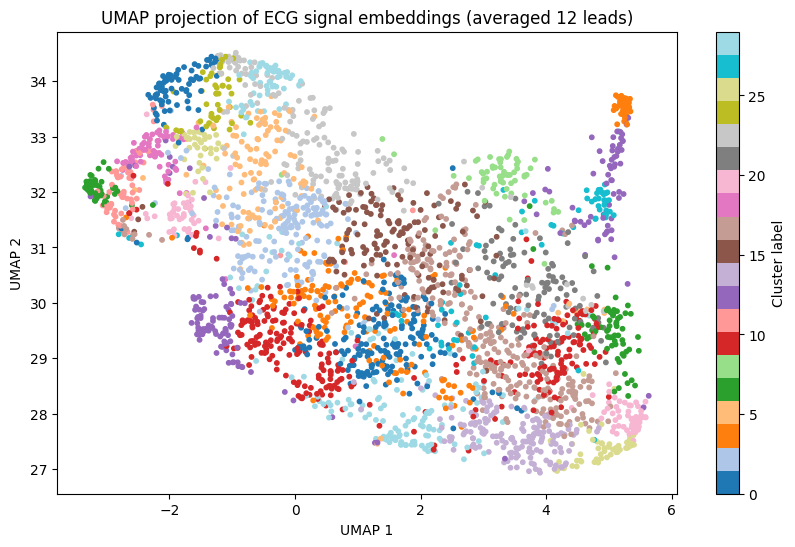

In [23]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(embeddings_signals)  # shape: (n_signals, 2)

plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=labels, cmap='tab20', s=10)
plt.colorbar(scatter, label="Cluster label")
plt.title("UMAP projection of ECG signal embeddings (averaged 12 leads)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


In [34]:
import tqdm
import numpy as np
import os

# Папка для сохранения эмбеддингов отведения II
save_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_lead2"
os.makedirs(save_dir, exist_ok=True)

n_samples = len(df)   # можно выбрать меньше для теста
chunk_size = 200      # увеличиваем батч до 200
lead_index = 1        # отведение II


### построение эмбеддингов на всем наборе данных для 2 отведения

In [35]:
for start in range(0, n_samples, chunk_size):
    end = min(start + chunk_size, n_samples)
    actual_chunk_size = end - start
    embeddings_chunk = np.zeros((actual_chunk_size, 768), dtype=np.float32)  # для одного отведения

    for i, ecg_id in enumerate(tqdm.tqdm(df.index[start:end], desc=f"Processing {start}-{end}")):
        # Загружаем сигнал и предобрабатываем
        sig, meta = load_ptbxl_lr(ecg_id)
        sig_pre = preprocess_one(sig, orig_fs=int(meta.get("fs",100)))
        
        # Берём только отведение II
        x = torch.tensor(sig_pre[lead_index], dtype=torch.float32)[None, :].to(device)
        with torch.no_grad():
            output = hubert_ecg(input_values=x)
            emb = output.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
        embeddings_chunk[i] = emb

    # Сохраняем батч
    chunk_file = os.path.join(save_dir, f"embeddings_lead2_{start}_{end}.npy")
    np.save(chunk_file, embeddings_chunk)
    print(f"Saved {chunk_file}")


Processing 0-200: 100%|██████████| 200/200 [00:03<00:00, 52.21it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_0_200.npy


Processing 200-400: 100%|██████████| 200/200 [00:03<00:00, 50.33it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_200_400.npy


Processing 400-600: 100%|██████████| 200/200 [00:03<00:00, 55.94it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_400_600.npy


Processing 600-800: 100%|██████████| 200/200 [00:03<00:00, 50.88it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_600_800.npy


Processing 800-1000: 100%|██████████| 200/200 [00:03<00:00, 53.28it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_800_1000.npy


Processing 1000-1200: 100%|██████████| 200/200 [00:03<00:00, 51.60it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_1000_1200.npy


Processing 1200-1400: 100%|██████████| 200/200 [00:03<00:00, 52.13it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_1200_1400.npy


Processing 1400-1600: 100%|██████████| 200/200 [00:03<00:00, 50.85it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_1400_1600.npy


Processing 1600-1800: 100%|██████████| 200/200 [00:03<00:00, 53.91it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_1600_1800.npy


Processing 1800-2000: 100%|██████████| 200/200 [00:03<00:00, 52.84it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_1800_2000.npy


Processing 2000-2200: 100%|██████████| 200/200 [00:03<00:00, 52.02it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_2000_2200.npy


Processing 2200-2400: 100%|██████████| 200/200 [00:03<00:00, 51.83it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_2200_2400.npy


Processing 2400-2600: 100%|██████████| 200/200 [00:03<00:00, 50.88it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_2400_2600.npy


Processing 2600-2800: 100%|██████████| 200/200 [00:03<00:00, 52.18it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_2600_2800.npy


Processing 2800-3000: 100%|██████████| 200/200 [00:03<00:00, 53.14it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_2800_3000.npy


Processing 3000-3200: 100%|██████████| 200/200 [00:03<00:00, 52.62it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_3000_3200.npy


Processing 3200-3400: 100%|██████████| 200/200 [00:03<00:00, 51.92it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_3200_3400.npy


Processing 3400-3600: 100%|██████████| 200/200 [00:03<00:00, 51.56it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_3400_3600.npy


Processing 3600-3800: 100%|██████████| 200/200 [00:03<00:00, 51.42it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_3600_3800.npy


Processing 3800-4000: 100%|██████████| 200/200 [00:03<00:00, 50.30it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_3800_4000.npy


Processing 4000-4200: 100%|██████████| 200/200 [00:03<00:00, 51.35it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_4000_4200.npy


Processing 4200-4400: 100%|██████████| 200/200 [00:03<00:00, 52.56it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_4200_4400.npy


Processing 4400-4600: 100%|██████████| 200/200 [00:03<00:00, 51.55it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_4400_4600.npy


Processing 4600-4800: 100%|██████████| 200/200 [00:03<00:00, 51.04it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_4600_4800.npy


Processing 4800-5000: 100%|██████████| 200/200 [00:03<00:00, 50.59it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_4800_5000.npy


Processing 5000-5200: 100%|██████████| 200/200 [00:03<00:00, 51.54it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_5000_5200.npy


Processing 5200-5400: 100%|██████████| 200/200 [00:03<00:00, 50.13it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_5200_5400.npy


Processing 5400-5600: 100%|██████████| 200/200 [00:03<00:00, 52.49it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_5400_5600.npy


Processing 5600-5800: 100%|██████████| 200/200 [00:03<00:00, 51.73it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_5600_5800.npy


Processing 5800-6000: 100%|██████████| 200/200 [00:03<00:00, 50.97it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_5800_6000.npy


Processing 6000-6200: 100%|██████████| 200/200 [00:03<00:00, 51.64it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_6000_6200.npy


Processing 6200-6400: 100%|██████████| 200/200 [00:03<00:00, 50.87it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_6200_6400.npy


Processing 6400-6600: 100%|██████████| 200/200 [00:03<00:00, 51.08it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_6400_6600.npy


Processing 6600-6800: 100%|██████████| 200/200 [00:03<00:00, 51.32it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_6600_6800.npy


Processing 6800-7000: 100%|██████████| 200/200 [00:03<00:00, 52.39it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_6800_7000.npy


Processing 7000-7200: 100%|██████████| 200/200 [00:03<00:00, 51.22it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_7000_7200.npy


Processing 7200-7400: 100%|██████████| 200/200 [00:03<00:00, 51.54it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_7200_7400.npy


Processing 7400-7600: 100%|██████████| 200/200 [00:03<00:00, 52.11it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_7400_7600.npy


Processing 7600-7800: 100%|██████████| 200/200 [00:03<00:00, 52.84it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_7600_7800.npy


Processing 7800-8000: 100%|██████████| 200/200 [00:03<00:00, 51.06it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_7800_8000.npy


Processing 8000-8200: 100%|██████████| 200/200 [00:03<00:00, 52.58it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_8000_8200.npy


Processing 8200-8400: 100%|██████████| 200/200 [00:03<00:00, 51.98it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_8200_8400.npy


Processing 8400-8600: 100%|██████████| 200/200 [00:03<00:00, 52.45it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_8400_8600.npy


Processing 8600-8800: 100%|██████████| 200/200 [00:03<00:00, 50.64it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_8600_8800.npy


Processing 8800-9000: 100%|██████████| 200/200 [00:03<00:00, 50.04it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_8800_9000.npy


Processing 9000-9200: 100%|██████████| 200/200 [00:03<00:00, 51.30it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_9000_9200.npy


Processing 9200-9400: 100%|██████████| 200/200 [00:03<00:00, 50.51it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_9200_9400.npy


Processing 9400-9600: 100%|██████████| 200/200 [00:03<00:00, 50.90it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_9400_9600.npy


Processing 9600-9800: 100%|██████████| 200/200 [00:03<00:00, 51.70it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_9600_9800.npy


Processing 9800-10000: 100%|██████████| 200/200 [00:03<00:00, 51.80it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_9800_10000.npy


Processing 10000-10200: 100%|██████████| 200/200 [00:03<00:00, 50.13it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_10000_10200.npy


Processing 10200-10400: 100%|██████████| 200/200 [00:03<00:00, 51.92it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_10200_10400.npy


Processing 10400-10600: 100%|██████████| 200/200 [00:03<00:00, 52.29it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_10400_10600.npy


Processing 10600-10800: 100%|██████████| 200/200 [00:03<00:00, 52.74it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_10600_10800.npy


Processing 10800-11000: 100%|██████████| 200/200 [00:03<00:00, 50.05it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_10800_11000.npy


Processing 11000-11200: 100%|██████████| 200/200 [00:03<00:00, 50.87it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_11000_11200.npy


Processing 11200-11400: 100%|██████████| 200/200 [00:03<00:00, 52.42it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_11200_11400.npy


Processing 11400-11600: 100%|██████████| 200/200 [00:03<00:00, 53.78it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_11400_11600.npy


Processing 11600-11800: 100%|██████████| 200/200 [00:03<00:00, 51.61it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_11600_11800.npy


Processing 11800-12000: 100%|██████████| 200/200 [00:03<00:00, 51.96it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_11800_12000.npy


Processing 12000-12200: 100%|██████████| 200/200 [00:03<00:00, 52.29it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_12000_12200.npy


Processing 12200-12400: 100%|██████████| 200/200 [00:03<00:00, 51.28it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_12200_12400.npy


Processing 12400-12600: 100%|██████████| 200/200 [00:03<00:00, 52.44it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_12400_12600.npy


Processing 12600-12800: 100%|██████████| 200/200 [00:03<00:00, 50.96it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_12600_12800.npy


Processing 12800-13000: 100%|██████████| 200/200 [00:03<00:00, 51.81it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_12800_13000.npy


Processing 13000-13200: 100%|██████████| 200/200 [00:03<00:00, 50.05it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_13000_13200.npy


Processing 13200-13400: 100%|██████████| 200/200 [00:03<00:00, 51.99it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_13200_13400.npy


Processing 13400-13600: 100%|██████████| 200/200 [00:03<00:00, 51.87it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_13400_13600.npy


Processing 13600-13800: 100%|██████████| 200/200 [00:03<00:00, 51.07it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_13600_13800.npy


Processing 13800-14000: 100%|██████████| 200/200 [00:03<00:00, 51.69it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_13800_14000.npy


Processing 14000-14200: 100%|██████████| 200/200 [00:03<00:00, 51.16it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_14000_14200.npy


Processing 14200-14400: 100%|██████████| 200/200 [00:03<00:00, 50.22it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_14200_14400.npy


Processing 14400-14600: 100%|██████████| 200/200 [00:03<00:00, 52.49it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_14400_14600.npy


Processing 14600-14800: 100%|██████████| 200/200 [00:03<00:00, 52.37it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_14600_14800.npy


Processing 14800-15000: 100%|██████████| 200/200 [00:03<00:00, 51.10it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_14800_15000.npy


Processing 15000-15200: 100%|██████████| 200/200 [00:03<00:00, 51.95it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_15000_15200.npy


Processing 15200-15400: 100%|██████████| 200/200 [00:03<00:00, 51.46it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_15200_15400.npy


Processing 15400-15600: 100%|██████████| 200/200 [00:03<00:00, 50.83it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_15400_15600.npy


Processing 15600-15800: 100%|██████████| 200/200 [00:03<00:00, 51.74it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_15600_15800.npy


Processing 15800-16000: 100%|██████████| 200/200 [00:03<00:00, 51.40it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_15800_16000.npy


Processing 16000-16200: 100%|██████████| 200/200 [00:03<00:00, 50.00it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_16000_16200.npy


Processing 16200-16400: 100%|██████████| 200/200 [00:03<00:00, 52.28it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_16200_16400.npy


Processing 16400-16600: 100%|██████████| 200/200 [00:03<00:00, 52.63it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_16400_16600.npy


Processing 16600-16800: 100%|██████████| 200/200 [00:04<00:00, 49.57it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_16600_16800.npy


Processing 16800-17000: 100%|██████████| 200/200 [00:03<00:00, 51.43it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_16800_17000.npy


Processing 17000-17200: 100%|██████████| 200/200 [00:04<00:00, 49.84it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_17000_17200.npy


Processing 17200-17400: 100%|██████████| 200/200 [00:03<00:00, 50.34it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_17200_17400.npy


Processing 17400-17600: 100%|██████████| 200/200 [00:03<00:00, 52.35it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_17400_17600.npy


Processing 17600-17800: 100%|██████████| 200/200 [00:03<00:00, 51.70it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_17600_17800.npy


Processing 17800-18000: 100%|██████████| 200/200 [00:03<00:00, 52.20it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_17800_18000.npy


Processing 18000-18200: 100%|██████████| 200/200 [00:03<00:00, 51.68it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_18000_18200.npy


Processing 18200-18400: 100%|██████████| 200/200 [00:03<00:00, 52.71it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_18200_18400.npy


Processing 18400-18600: 100%|██████████| 200/200 [00:03<00:00, 51.94it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_18400_18600.npy


Processing 18600-18800: 100%|██████████| 200/200 [00:03<00:00, 52.29it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_18600_18800.npy


Processing 18800-19000: 100%|██████████| 200/200 [00:03<00:00, 51.39it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_18800_19000.npy


Processing 19000-19200: 100%|██████████| 200/200 [00:03<00:00, 52.45it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_19000_19200.npy


Processing 19200-19400: 100%|██████████| 200/200 [00:03<00:00, 52.58it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_19200_19400.npy


Processing 19400-19600: 100%|██████████| 200/200 [00:03<00:00, 51.31it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_19400_19600.npy


Processing 19600-19800: 100%|██████████| 200/200 [00:03<00:00, 50.50it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_19600_19800.npy


Processing 19800-20000: 100%|██████████| 200/200 [00:03<00:00, 52.37it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_19800_20000.npy


Processing 20000-20200: 100%|██████████| 200/200 [00:03<00:00, 51.32it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_20000_20200.npy


Processing 20200-20400: 100%|██████████| 200/200 [00:03<00:00, 51.30it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_20200_20400.npy


Processing 20400-20600: 100%|██████████| 200/200 [00:03<00:00, 51.43it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_20400_20600.npy


Processing 20600-20800: 100%|██████████| 200/200 [00:03<00:00, 50.83it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_20600_20800.npy


Processing 20800-21000: 100%|██████████| 200/200 [00:03<00:00, 51.32it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_20800_21000.npy


Processing 21000-21200: 100%|██████████| 200/200 [00:03<00:00, 52.01it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_21000_21200.npy


Processing 21200-21400: 100%|██████████| 200/200 [00:03<00:00, 52.92it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_21200_21400.npy


Processing 21400-21600: 100%|██████████| 200/200 [00:03<00:00, 51.36it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_21400_21600.npy


Processing 21600-21799: 100%|██████████| 199/199 [00:03<00:00, 50.60it/s]

Saved /Users/elizaveta/vs project/jupyter project/embeddings_lead2/embeddings_lead2_21600_21799.npy


In [36]:
import numpy as np
import os

save_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_lead2"
all_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".npy")])

all_embeddings = []

for f in all_files:
    path = os.path.join(save_dir, f)
    emb_chunk = np.load(path)
    all_embeddings.append(emb_chunk)

# Объединяем все батчи в один массив
all_embeddings = np.vstack(all_embeddings)
print("Final embeddings shape:", all_embeddings.shape)  # ожидаем (n_samples, 768)


Final embeddings shape: (21799, 768)


Embeddings shape: (21799, 768)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3

Silhouette score: 0.0594179593026638
Average intra-cluster distance: 11.907391
Average inter-cluster distance: 12.611635


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


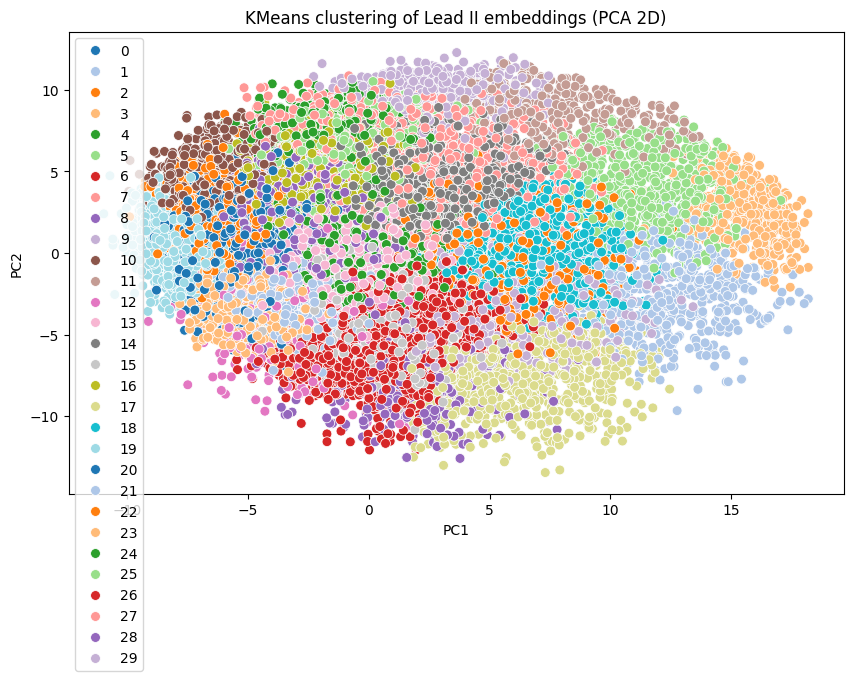

Cluster 0: 710 embeddings
Cluster 1: 1164 embeddings
Cluster 2: 440 embeddings
Cluster 3: 397 embeddings
Cluster 4: 490 embeddings
Cluster 5: 379 embeddings
Cluster 6: 1106 embeddings
Cluster 7: 448 embeddings
Cluster 8: 886 embeddings
Cluster 9: 492 embeddings
Cluster 10: 602 embeddings
Cluster 11: 323 embeddings
Cluster 12: 473 embeddings
Cluster 13: 1190 embeddings
Cluster 14: 875 embeddings
Cluster 15: 609 embeddings
Cluster 16: 810 embeddings
Cluster 17: 767 embeddings
Cluster 18: 792 embeddings
Cluster 19: 956 embeddings
Cluster 20: 1043 embeddings
Cluster 21: 493 embeddings
Cluster 22: 1018 embeddings
Cluster 23: 1390 embeddings
Cluster 24: 858 embeddings
Cluster 25: 617 embeddings
Cluster 26: 1158 embeddings
Cluster 27: 495 embeddings
Cluster 28: 392 embeddings
Cluster 29: 426 embeddings


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- all_embeddings должен быть (n_samples, 768) ---
print("Embeddings shape:", all_embeddings.shape)

# --- 1. Кластеризация ---
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(all_embeddings)

# --- 2. Метрики ---
sil_score = silhouette_score(all_embeddings, labels)
intra_distances = []
inter_distances = []

for i in range(n_clusters):
    cluster_points = all_embeddings[labels == i]
    if len(cluster_points) > 1:
        dists = pairwise_distances(cluster_points)
        intra_distances.append(np.mean(dists))
        
# межкластерные расстояния (среднее между центрами)
centers = kmeans.cluster_centers_
inter_distances = pairwise_distances(centers)
avg_intra = np.mean(intra_distances)
avg_inter = np.mean(inter_distances)

print("Silhouette score:", sil_score)
print("Average intra-cluster distance:", avg_intra)
print("Average inter-cluster distance:", avg_inter)

# --- 3. PCA для визуализации ---
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels, palette='tab20', legend='full', s=50)
plt.title("KMeans clustering of Lead II embeddings (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [45]:
import numpy as np
import os

save_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_lead2"
embedding_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".npy")])

for f in embedding_files:
    arr = np.load(os.path.join(save_dir, f))
    print(f, arr.shape)


embeddings_lead2_0_200.npy (200, 768)
embeddings_lead2_10000_10200.npy (200, 768)
embeddings_lead2_1000_1200.npy (200, 768)
embeddings_lead2_10200_10400.npy (200, 768)
embeddings_lead2_10400_10600.npy (200, 768)
embeddings_lead2_10600_10800.npy (200, 768)
embeddings_lead2_10800_11000.npy (200, 768)
embeddings_lead2_11000_11200.npy (200, 768)
embeddings_lead2_11200_11400.npy (200, 768)
embeddings_lead2_11400_11600.npy (200, 768)
embeddings_lead2_11600_11800.npy (200, 768)
embeddings_lead2_11800_12000.npy (200, 768)
embeddings_lead2_12000_12200.npy (200, 768)
embeddings_lead2_1200_1400.npy (200, 768)
embeddings_lead2_12200_12400.npy (200, 768)
embeddings_lead2_12400_12600.npy (200, 768)
embeddings_lead2_12600_12800.npy (200, 768)
embeddings_lead2_12800_13000.npy (200, 768)
embeddings_lead2_13000_13200.npy (200, 768)
embeddings_lead2_13200_13400.npy (200, 768)
embeddings_lead2_13400_13600.npy (200, 768)
embeddings_lead2_13600_13800.npy (200, 768)
embeddings_lead2_13800_14000.npy (200, 768

In [46]:
X_all = np.vstack([np.load(os.path.join(save_dir, f)) for f in embedding_files])
print(X_all.shape)


(21799, 768)


In [48]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# One-vs-Rest для мульти-лейбл
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train, y_train)

# Предсказания
y_pred = clf.predict(X_test)

# Метрики
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_los

Accuracy: 0.0
              precision    recall  f1-score   support

        1AVB       0.04      0.34      0.07        79
        2AVB       0.00      0.00      0.00         1
        3AVB       0.00      0.00      0.00         2
       ABQRS       0.14      0.40      0.20       322
        AFIB       0.06      0.33      0.10       152
        AFLT       0.02      0.14      0.04         7
        ALMI       0.01      0.11      0.02        27
         AMI       0.01      0.14      0.02        35
       ANEUR       0.00      0.00      0.00        10
        ASMI       0.09      0.37      0.15       234
        BIGU       0.00      0.00      0.00         8
       CLBBB       0.02      0.24      0.04        54
       CRBBB       0.02      0.22      0.04        54
         DIG       0.00      0.00      0.00        18
          EL       0.00      0.00      0.00         9
       HVOLT       0.00      0.00      0.00         6
       ILBBB       0.00      0.00      0.00         8
        ILMI 

In [49]:
from sklearn.metrics import f1_score, hamming_loss, average_precision_score

# F1
print("Micro F1:", f1_score(y_test, y_pred, average='micro'))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))

# Hamming loss (доля неправильно предсказанных меток)
print("Hamming loss:", hamming_loss(y_test, y_pred))

# Average precision для мульти-лейбл
print("Average precision:", average_precision_score(y_test, y_pred))


Micro F1: 0.15593551538837322
Macro F1: 0.05076081135302085
Hamming loss: 0.16607287034307758
Average precision: 0.038987517306527456


In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, hamming_loss, classification_report

# Нормализация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Мульти-лейбл классификатор
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train_scaled, y_train)

# Предсказания
y_pred = clf.predict(X_test_scaled)

# Метрики
print("Micro F1:", f1_score(y_test, y_pred, average='micro'))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Hamming loss:", hamming_loss(y_test, y_pred))

# Можно посмотреть отчёт по каждому классу
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_los

Micro F1: 0.15950920245398773
Macro F1: 0.050661529681741105
Hamming loss: 0.16065180894282896
              precision    recall  f1-score   support

        1AVB       0.04      0.37      0.08        79
        2AVB       0.00      0.00      0.00         1
        3AVB       0.00      0.00      0.00         2
       ABQRS       0.14      0.40      0.21       322
        AFIB       0.06      0.34      0.11       152
        AFLT       0.04      0.14      0.06         7
        ALMI       0.01      0.11      0.02        27
         AMI       0.01      0.14      0.02        35
       ANEUR       0.00      0.00      0.00        10
        ASMI       0.09      0.35      0.15       234
        BIGU       0.00      0.00      0.00         8
       CLBBB       0.02      0.24      0.04        54
       CRBBB       0.03      0.24      0.05        54
         DIG       0.00      0.00      0.00        18
          EL       0.00      0.00      0.00         9
       HVOLT       0.00      0.00      0

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

In [51]:
from sklearn.preprocessing import MultiLabelBinarizer

# scp_codes — колонка вида ['NORM', 'SR'] или 'NORM SR' (строка)
df['labels'] = df['scp_codes'].apply(lambda x: x.split(' '))  # если строка с пробелами

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])  # shape = (n_samples, n_classes)


In [52]:
train_idx = df['strat_fold'].isin([1,2,3,4,5,6,7,8])
val_idx   = df['strat_fold'] == 9
test_idx  = df['strat_fold'] == 10

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train, y_train)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_los

,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None


In [54]:
y_pred = clf.predict(X_test)

from sklearn.metrics import f1_score, hamming_loss
print("Micro F1:", f1_score(y_test, y_pred, average='micro'))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Hamming loss:", hamming_loss(y_test, y_pred))


Micro F1: 0.22696521321635896
Macro F1: 0.04315451687629486
Hamming loss: 0.11849676176202965


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_los

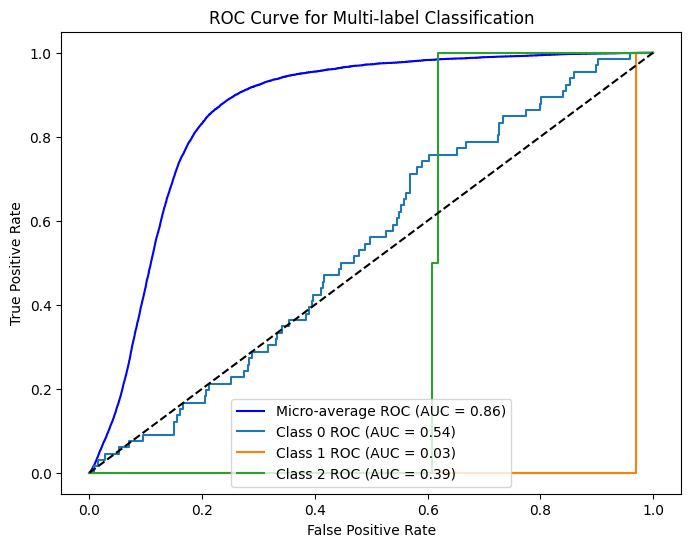

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train, y_train)

# вероятности для всех классов
y_pred_prob = clf.predict_proba(X_test)


n_classes = y_test.shape[1]

# Для micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(8,6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='blue')

# Для отдельных классов (например, 0, 1, 2)
for i in range(min(3, n_classes)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} ROC (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # случайная линия
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-label Classification')
plt.legend()
plt.show()
